# Flaml (Fast and Lightweight AutoML) Time Series Forecast Demo

Restart runtime after installation (ignore errors). 0.9.4 has some model choosing bugs.

In [ ]:
!pip3 install "flaml[ts_forecast]"==0.9.3

     |████████████████████████████████| 141 kB 4.3 MB/s 
     |████████████████████████████████| 2.0 MB 24.3 MB/s 
     |████████████████████████████████| 65 kB 4.1 MB/s 
     |████████████████████████████████| 9.8 MB 58.7 MB/s 
     |████████████████████████████████| 49 kB 5.6 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640437 sha256=fe77324154f7483d2efa5b741b87cfd4f8eb4119bf2006f4369f5f0df43d4c71
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
  Attempting uninstall: statsmodels
    Found e

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from flaml import AutoML

### Import dataset

In [ ]:
df = sns.load_dataset('flights')
df

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121
...,...,...,...
139,1960,Aug,606
140,1960,Sep,508
141,1960,Oct,461
142,1960,Nov,390


### Preprocessing

The first column must to be continuous ```datetime64``` values

In [ ]:
t = pd.to_datetime(df.year.astype('str') + '-' + df.month.astype('str'), format='%Y-%b')
df.insert(0, 'timestamp', t)
df = df.drop(['year', 'month'], axis=1)
df

,timestamp,passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


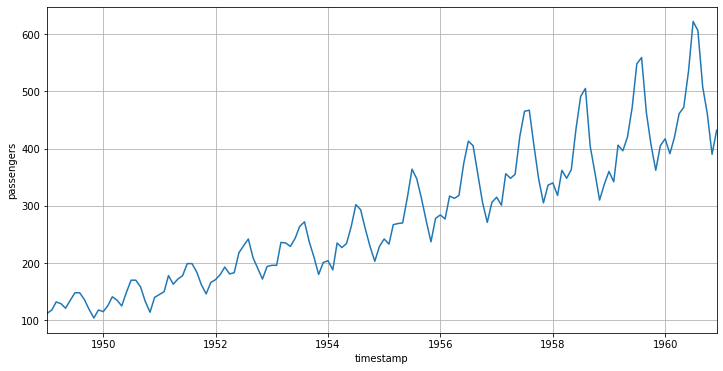

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='timestamp', y='passengers')
plt.xlim([df.timestamp[0], df.timestamp[df.index.size-1]])
plt.grid(True)
plt.show()

### Train model

Use 20% data as test dataset

In [ ]:
split = 0.2
split_index = int(df.index.size*(1-split))

train, test = df[:split_index], df[split_index:].drop(['passengers'], axis=1)

In [ ]:
reg = AutoML()
reg.fit(dataframe=train, label='passengers', task='ts_forecast', split_type='time', period=36, time_budget=60)

[flaml.automl: 01-09 16:24:09] {1973} INFO - task = ts_forecast
[flaml.automl: 01-09 16:24:09] {1975} INFO - Data split method: time
[flaml.automl: 01-09 16:24:09] {1979} INFO - Evaluation method: cv
[flaml.automl: 01-09 16:24:09] {1201} INFO - Using nsplits=2 due to data size limit.
[flaml.automl: 01-09 16:24:09] {2071} INFO - Minimizing error metric: mape
[flaml.automl: 01-09 16:24:09] {2123} INFO - List of ML learners in AutoML Run: ['prophet', 'arima', 'sarimax']
[flaml.automl: 01-09 16:24:09] {2380} INFO - iteration 0, current learner prophet
[flaml.automl: 01-09 16:24:16] {2494} INFO - Estimated sufficient time budget=67412s. Estimated necessary time budget=67s.
INFO:flaml.automl:Estimated sufficient time budget=67412s. Estimated necessary time budget=67s.
[flaml.automl: 01-09 16:24:16] {2545} INFO -  at 7.1s,	estimator prophet's best error=0.0441,	best estimator prophet's best error=0.0441
INFO:flaml.automl: at 7.1s,	estimator prophet's best error=0.0441,	best estimator prophet'

In [ ]:
print('Best ML leaner:', reg.best_estimator)
print('Best hyperparmeter config:', reg.best_config)

Best ML leaner: prophet
Best hyperparmeter config: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 9.907664630875948, 'holidays_prior_scale': 6.372933414610401, 'seasonality_mode': 'multiplicative'}


### Predict values

If the model is *Prophet*, pass a DataFrame with timestamps to the ```predict()``` method.

If the model is *ARIMA* or *SARIMAX*, pass a number (number of future values to be predicted). 

In [ ]:
if reg.best_estimator == 'prophet':
  predicted = reg.predict(test)  # prophet
else:
  reg.predict(test.index.size)  # arima/sarimax

predicted.index = test.index  # use test DataFrame index
predicted

115    481.414994
116    425.953437
117    370.054510
118    321.826565
119    365.513180
120    373.317561
121    363.686584
122    411.917009
123    401.497661
124    411.557305
125    471.221905
126    537.270811
127    517.442129
128    461.822571
129    399.929155
130    344.433148
131    394.651835
132    403.061587
133    396.452131
134    454.337014
135    439.315042
136    439.772153
137    515.647580
138    560.413885
139    565.307534
140    490.835078
141    428.215269
142    379.155906
143    422.516086
Name: yhat, dtype: float64

In [ ]:
from sklearn.metrics import mean_absolute_error

print('Prection MAE:', mean_absolute_error(df[split_index:].passengers, predicted).round(3))

Prection MAE: 18.675


### Predict future new values

In [ ]:
new_test = pd.DataFrame({'timestamp': pd.date_range(start='1960-12-01', end='1963-12-01', freq='MS')})

if reg.best_estimator == 'prophet':
  new_predicted = reg.predict(new_test)
else:
  reg.predict(new_test.index.size)

new_predicted

0     422.516086
1     430.747138
2     410.441926
3     483.237653
4     468.078913
5     472.016016
6     548.779811
7     605.858158
8     601.477570
9     526.695168
10    458.188405
11    401.707712
12    451.524368
13    460.368760
14    443.274657
15    511.530210
16    496.552822
17    504.457610
18    581.574629
19    652.093386
20    637.151831
21    562.809174
22    488.171069
23    423.858372
24    480.645860
25    490.127829
26    476.732806
27    539.196675
28    524.749735
29    537.106100
30    614.047372
31    699.108202
32    672.316831
33    599.177562
34    518.153825
35    445.617745
36    509.894073
Name: yhat, dtype: float64

### Visualization

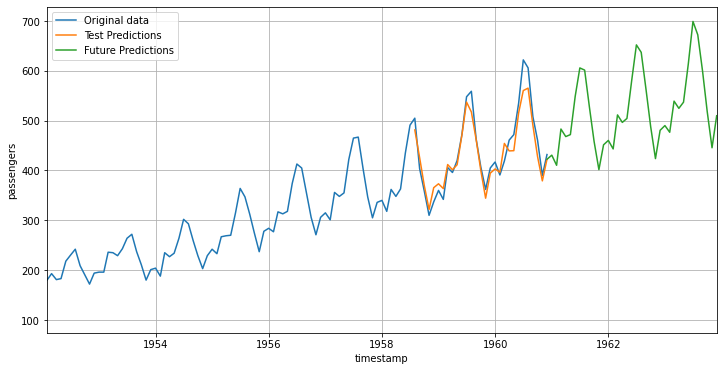

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='timestamp', y='passengers', label='Original data')
sns.lineplot(x=test.timestamp, y=predicted, label='Test Predictions')
sns.lineplot(x=new_test.timestamp, y=new_predicted, label='Future Predictions')
plt.xlim([df.timestamp[new_test.index.size], new_test.timestamp[new_test.index.size-1]])
plt.grid(True)
plt.show()